In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess

from datetime import date

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

USER = os.environ['USER']
os.environ['CESMDATAROOT'] = f'/glade/scratch/{USER}/inputdata'
import pop_tools

import regrid_tools
import util

In [3]:
mom6_grid_file = '/glade/p/cesmdata/cseg/inputdata/share/scripgrids/tx0.66v1_SCRIP_190314.nc'
fesedflux_file = '/glade/work/mclong/cesm_inputdata/fesedflux_total_reduce_oxic_POP_gx1v7.c200618.nc'

# Need some mom grid information
mom_case = "mom_oob.003"
mom_hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", "archive", mom_case, "ocn", "hist")
mom_static_ds = xr.open_dataset(os.path.join(mom_hist_dir, f"{mom_case}.mom6.static.nc"))

src_grid = regrid_tools.grid('POP_gx1v7', clobber=False)
dst_grid = regrid_tools.grid('tx0.66v1', grid_file=mom6_grid_file)
method = 'conserve'

regridder = regrid_tools.regridder(src_grid, dst_grid, method, clobber=False)
regridder

exists: /glade/work/mlevy/adhoc-regridding/POP_gx1v7.nc
source grid dims: (384, 320)
destination grid dims: (458, 540)


regridder POP_gx1v7.nc --> tx0.66v1_SCRIP_190314.nc

In [4]:
if mom_static_ds.area_t.attrs['units'] == 'm2':
    mom_static_ds.area_t.data = mom_static_ds.area_t.data * 1e4
    mom_static_ds.area_t.attrs['units'] = 'cm2'

In [5]:
ds_src = xr.open_dataset(fesedflux_file)
ds_src.info()

xarray.Dataset {
dimensions:
	z_t = 60 ;
	nlat = 384 ;
	nlon = 320 ;

variables:
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe sediment flux (total) ;
	float32 FESEDFLUXIN_oxic(z_t, nlat, nlon) ;
		FESEDFLUXIN_oxic:units = micromol m$^{-2}$ d$^{-1}$ ;
		FESEDFLUXIN_oxic:long_name = Fe sediment flux (oxic) ;
	float32 FESEDFLUXIN_reduce(z_t, nlat, nlon) ;
		FESEDFLUXIN_reduce:units = micromol m$^{-2}$ d$^{-1}$ ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 z_t(z_t) ;
		z_t:units = cm ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:positive = down ;

// global attributes:
	:history

In [6]:
def compute_weighted_sum(da, da_wgt):
    return np.sum(da.data * da_wgt.data)

FESEDFLUXIN


/glade/work/mlevy/miniconda3/envs/forcing-Fe-sedflux/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


10
20
30
40
50
60
FESEDFLUXIN_oxic
10
20
30
40
50
60
FESEDFLUXIN_reduce
10
20
30
40
50
60
fesedflux total sum on POP grid before fill: 3.896945e+17
fesedflux total sum on POP grid after fill: 3.201342e+18
CPU times: user 1min 38s, sys: 58.1 s, total: 2min 36s
Wall time: 2min 2s


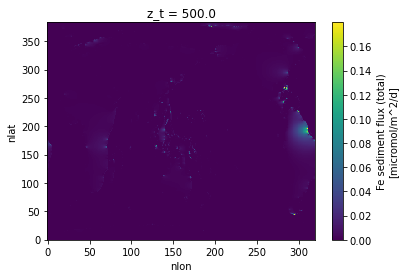

In [7]:
%%time
# Apply POP mask to data, and then use pop_tools to fill it in
# (rather than treating POP land / subocean cells as 0)
for var in ds_src.variables:
    if var.startswith("FESED"):
        print(var)

        # Print sum prior to fill
        if var == "FESEDFLUXIN":
            prefill_sum = compute_weighted_sum(ds_src["FESEDFLUXIN"].sum("z_t"), ds_src["TAREA"])

        for k in range(60):
            if (k%10 == 9):
                print(k+1)
            ds_src[var].data[k,:,:] = np.where(k < ds_src["KMT"].data, ds_src[var].data[k,:,:], np.nan)
            # Want to fill globally; ds_src["KMT"] is always >= 0
            # Want to use SOR, but got a divide-by-0 error in FESEDFLUXIN_reduce
            ds_src[var].data[k,:,:] = pop_tools.lateral_fill(ds_src.isel(z_t=k)[var], ds_src["KMT"]>=0, use_sor=not (var == "FESEDFLUXIN_reduce" and (k==0 or k>=49))).data

        # Print sum following fill
        if var == "FESEDFLUXIN":
            postfill_sum = compute_weighted_sum(ds_src["FESEDFLUXIN"].sum("z_t"), ds_src["TAREA"])

#
try:
    print(f'fesedflux total sum on POP grid before fill: {prefill_sum:e}')
    print(f'fesedflux total sum on POP grid after fill: {postfill_sum:e}')
except:
    pass

ds_src.isel(z_t=0).FESEDFLUXIN.plot()

fesedflux total sum on MOM grid: 8.251566e+17


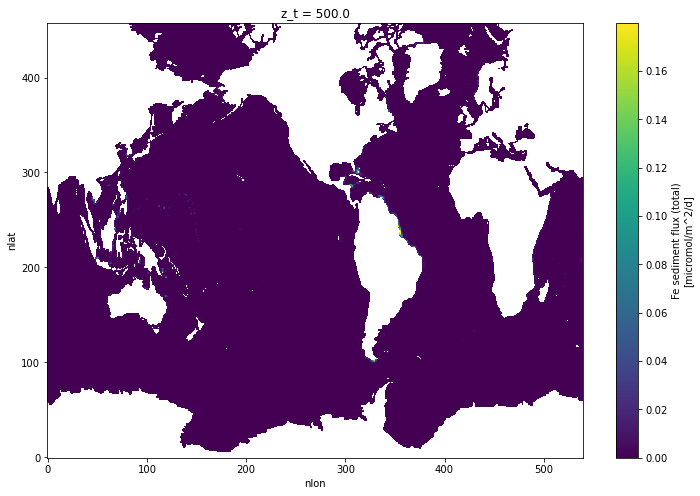

In [8]:
ds_dst_xy = regridder.regrid(ds_src, renormalize=True, apply_mask=True)
print(f'fesedflux total sum on MOM grid: {compute_weighted_sum(ds_dst_xy["FESEDFLUXIN"].sum("z_t"), mom_static_ds["area_t"]):e}')
ds_dst_xy.isel(z_t=0).FESEDFLUXIN.plot(figsize=[12,8])

In [9]:
# depth = xr.DataArray(
#     np.concatenate((
#         np.arange(0., 105., 5.), 
#         np.arange(125., 525., 25.), 
#         np.arange(550., 2050., 50.), 
#         np.arange(2100., 5600., 100.), # MNL: changed 6600 -> 5600 to match initial condition depths
#     )), 
#     dims=('DEPTH'), 
#     name='DEPTH',
#     attrs=dict(
#         long_name='Depth',
#         units='m',
#     )
# )

if ds_dst_xy['z_t'].attrs['units'] == 'cm':
    ds_dst = ds_dst_xy.assign_coords(z_t=ds_dst_xy['z_t'].data/100.)
    ds_dst['z_t'].attrs['units'] = 'm'
    ds_dst['z_t'].attrs['edges'] = 'DEPTH_EDGES'
else:
    ds_dst = ds_dst_xy

# Add edges to ds_dst
da_edges = xr.DataArray([0.] + list(pop_tools.get_grid('POP_gx1v7')['z_w_bot'].data/100.),
                        name='DEPTH_EDGES',
                        dims='DEPTH_EDGES')
da_edges.attrs['units'] = 'm'
da_edges
ds_dst['DEPTH_EDGES'] = da_edges

# depth
ds_dst = ds_dst.rename({'nlat': 'NLAT', 'nlon': 'NLON', 'z_t': 'DEPTH'})
ds_dst

<xarray.Dataset>
Dimensions:             (DEPTH: 60, NLAT: 458, NLON: 540, DEPTH_EDGES: 61)
Coordinates:
  * DEPTH               (DEPTH) float64 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
  * DEPTH_EDGES         (DEPTH_EDGES) float64 0.0 10.0 20.0 ... 5.25e+03 5.5e+03
Dimensions without coordinates: NLAT, NLON
Data variables:
    FESEDFLUXIN         (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    FESEDFLUXIN_oxic    (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    FESEDFLUXIN_reduce  (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    KMT                 (NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    TAREA               (NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    history:  Thu Jun 18 13:21:06 2020: ncks -O --fl_fmt=64bit /glade/work/mc...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

### NO VERTICAL REGRIDDING

For now, we are leaving output on the POP vertical grid (with proper units)

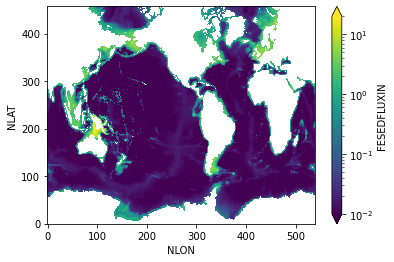

In [10]:
ds_dst.FESEDFLUXIN.sum('DEPTH').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))

In [11]:
ds_dst.attrs['note'] = f'temporary forcing file remapped from: {fesedflux_file}'
datestamp = date.today().strftime('%y%m%d')
path = f'{util.dirout}/fesedflux_total_reduce_oxic_{dst_grid.grid_name}.c{datestamp}.nc'


util.to_netcdf_clean(ds_dst, path, format='netcdf4')
util.ncks_fl_fmt64bit(path)

------------------------------
Writing /glade/work/mlevy/cesm_inputdata/fesedflux_total_reduce_oxic_tx0.66v1.c211025.nc
xarray.Dataset {
dimensions:
	DEPTH = 60 ;
	NLAT = 458 ;
	NLON = 540 ;
	DEPTH_EDGES = 61 ;

variables:
	float64 DEPTH(DEPTH) ;
		DEPTH:units = m ;
		DEPTH:edges = DEPTH_EDGES ;
	float64 FESEDFLUXIN(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe sediment flux (total) ;
	float64 FESEDFLUXIN_oxic(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN_oxic:units = micromol m$^{-2}$ d$^{-1}$ ;
		FESEDFLUXIN_oxic:long_name = Fe sediment flux (oxic) ;
	float64 FESEDFLUXIN_reduce(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN_reduce:units = micromol m$^{-2}$ d$^{-1}$ ;
	float64 KMT(NLAT, NLON) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 TAREA(NLAT, NLON) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
	float64 DEPTH_EDGES(DEPTH_EDGES) ;
		DEPTH_EDGES:units = m ;

// global attributes:
	:history = Thu Jun 18 13:21:06 2020: nck

In [12]:
feventflux_file = f'{util.inputdata}/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc'
ds_src_vent = xr.open_dataset(feventflux_file).rename(
    x='nlon',
    y='nlat',
    z='z_t',
)
ds_src_vent = xr.merge((ds_src_vent, pop_tools.get_grid('POP_gx1v7')[['z_t',]]))

# ds_src_vent.FESEDFLUXIN = pop_tools.lateral_fill(ds_src_vent.FESEDFLUXIN, isvalid_mask=(ds_src.KMT>=0))
ds_src_vent.FESEDFLUXIN.attrs['units'] = 'micromol/m^2/d'
ds_src_vent.FESEDFLUXIN.attrs['long_name'] = 'Fe geothermal vent flux'
ds_src_vent.z_t.attrs['units'] = 'cm'

ds_src_vent.info()

xarray.Dataset {
dimensions:
	z_t = 60 ;
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;

// global attributes:
}

10
20
30
40
50
60
feventflux total sum on POP grid before fill: 1.383013e+17
feventflux total sum on POP grid after fill: 2.397561e+17
CPU times: user 18.6 s, sys: 15.1 s, total: 33.7 s
Wall time: 25.5 s


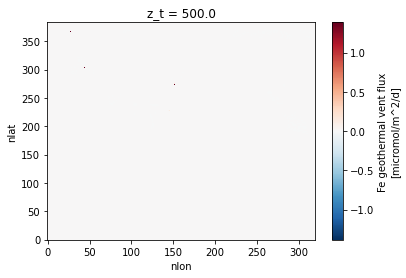

In [13]:
%%time
# Apply POP mask to data, and then use pop_tools to fill it in
# (rather than treating POP land / subocean cells as 0)
var = "FESEDFLUXIN"
prefill_sum = compute_weighted_sum(ds_src_vent["FESEDFLUXIN"].sum("z_t"), ds_src["TAREA"])
for k in range(60):
    if (k%10 == 9):
        print(k+1)
    ds_src_vent[var].data[k,:,:] = np.where(k < ds_src["KMT"].data, ds_src_vent[var].data[k,:,:], np.nan)
    # Want to fill globally; ds_src["KMT"] is always >= 0
    # Want to use SOR, but got a divide-by-0 error in some levels
    # (I think those levels are entirely populated by 0s?)
    ds_src_vent[var].data[k,:,:] = pop_tools.lateral_fill(ds_src_vent.isel(z_t=k)[var], ds_src["KMT"]>=0, use_sor=(k not in [10, 13, 59])).data

postfill_sum = compute_weighted_sum(ds_src_vent["FESEDFLUXIN"].sum("z_t"), ds_src["TAREA"])
print(f'feventflux total sum on POP grid before fill: {prefill_sum:e}')
print(f'feventflux total sum on POP grid after fill: {postfill_sum:e}')
ds_src_vent.isel(z_t=0).FESEDFLUXIN.plot()

In [14]:
ds_dst_vent_xy = regridder.regrid(ds_src_vent, renormalize=True, apply_mask=True)
print(f'feventflux total sum on MOM grid: {compute_weighted_sum(ds_dst_vent_xy["FESEDFLUXIN"].sum("z_t"), mom_static_ds["area_t"]):e}')
ds_dst_vent_xy

feventflux total sum on MOM grid: 1.572672e+17


<xarray.Dataset>
Dimensions:      (z_t: 60, nlat: 458, nlon: 540)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    FESEDFLUXIN  (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [15]:
# ds_dst_vent = regrid_vertical(ds_dst_vent_xy)

if ds_dst_vent_xy['z_t'].attrs['units'] == 'cm':
    ds_dst_vent = ds_dst_vent_xy.assign_coords(z_t=ds_dst_vent_xy['z_t'].data/100.)
    ds_dst_vent['z_t'].attrs['units'] = 'm'
    ds_dst_vent['z_t'].attrs['edges'] = 'DEPTH_EDGES'
else:
    ds_dst_vent = ds_dst_vent_xy

ds_dst_vent['DEPTH_EDGES'] = da_edges

# depth
ds_dst_vent = ds_dst_vent.rename({'nlat': 'NLAT', 'nlon': 'NLON', 'z_t': 'DEPTH'})
ds_dst_vent

<xarray.Dataset>
Dimensions:      (DEPTH: 60, NLAT: 458, NLON: 540, DEPTH_EDGES: 61)
Coordinates:
  * DEPTH        (DEPTH) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * DEPTH_EDGES  (DEPTH_EDGES) float64 0.0 10.0 20.0 ... 5e+03 5.25e+03 5.5e+03
Dimensions without coordinates: NLAT, NLON
Data variables:
    FESEDFLUXIN  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan

In [16]:
ds_dst_vent.attrs['note'] = f'temporary forcing file remapped from: {feventflux_file}'
datestamp = date.today().strftime('%y%m%d')
path = f'{util.dirout}/feventflux_5gmol_{dst_grid.grid_name}.c{datestamp}.nc'
util.to_netcdf_clean(ds_dst_vent, path, format='netcdf4')
util.ncks_fl_fmt64bit(path)

------------------------------
Writing /glade/work/mlevy/cesm_inputdata/feventflux_5gmol_tx0.66v1.c211025.nc
xarray.Dataset {
dimensions:
	DEPTH = 60 ;
	NLAT = 458 ;
	NLON = 540 ;
	DEPTH_EDGES = 61 ;

variables:
	float64 DEPTH(DEPTH) ;
		DEPTH:units = m ;
		DEPTH:edges = DEPTH_EDGES ;
	float64 FESEDFLUXIN(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;
	float64 DEPTH_EDGES(DEPTH_EDGES) ;
		DEPTH_EDGES:units = m ;

// global attributes:
	:note = temporary forcing file remapped from: /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc ;
	:history = created by https://github.com/marbl-ecosys/forcing-Fe-sedflux/tree/96f2a56 on 2021-10-25 ;
}
